# **Computer Assignment 2**
## **Stochastic Processes: The Fundamentals 2025-2026**

In [3]:
# Import libraries –––––
import pandas as pd
import numpy as np
import math

from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt

import nbformat
from tqdm import tqdm

## **Part I – Monte Carlo Simulation**

A Geometric Brownian Motion is described by the following stochastic differential equation (SDE):

$$
dS(t) = rS(t)dt + σS(t)dW (t) \tag{1}
$$

$$
S(0) = S_0,
$$

where $W$ is a Brownian Motion under the risk-neutral probability measure.

Let the expiry time of an option be $T$, and let

$$
N = \frac{T}{\Delta t}
$$

$$
S_n = S(n\Delta t).
$$

Then, given an initial price $S_0$, $M$ realizations of the path of a risky asset are generated using the algorithm (Euler method):

$$
S_{n+1} = S_n + S_n(r\Delta t + \sigma\sqrt{\Delta t}\phi),
$$

where $n$ indicates time and $φ$ is a normally distributed random variable with mean zero and unit variance.

We want to price a European call option with a maturity of 3 months and a strike price equal to USD 6,500. The annualized 3-month interest rate is equal to 3% (with quarterly compounding). Furthermore, use the value of the S&P-500 index on August 31, 2025 for the starting value $S_0$.

The price of an option can be calculated by computing the discounted value of the average payoff, i.e.

$$
V(S_0) = e^{-rT} \frac{1}{M} \sum_{m=1}^{M} \text{payoff}_m(S_N)
$$

where $r$ is a continuously compounded interest rate, $N$ is the total number of steps and $M$ is the number of paths.

In [5]:
# Import data –––––

# Read the CSV file into a DataFrame
dfSP500 = pd.read_csv("SP500.csv")

# Rename columns for consistency
dfSP500 = dfSP500.rename(columns={"SP500": "index_value"})

# Convert the observation_date column to datetime format
dfSP500['observation_date'] = pd.to_datetime(dfSP500['observation_date'])

# Calculate the number of months to cover in our sample
iNumber_of_months = 10*(2 + 11) - 2*11

# Select the last iNumber_of_months observations and reset the index
dfSP500 = dfSP500[len(dfSP500)-iNumber_of_months:].reset_index(drop=True)

# Calculating simple net returns using the definition –––––
for i in range(iNumber_of_months-1):
    dfSP500.loc[i, "simple_net_return"] = (dfSP500.loc[i+1, "index_value"] / dfSP500.loc[i, "index_value"]) - 1

# Define sample size
iSample_size = len(dfSP500) - 1

### **Question (a)**

Provide an estimate of parameter $σ$ in model $(1)$ by using the data that was obtained for the first part of computer assignment 1.
Use the binomial tree method (constructed in the second part of the first computer assignment) to calculate the price of a European call option with maturity 3 months and strike price USD 6,500.
Use 300 steps in the tree.
Compare your result with the Black-Scholes value of the call option.
For $u$ and $d$ you can use:

$$
u = e^{\sigma \sqrt{\Delta t}}
$$

$$
d = e^{−\sigma \sqrt{\Delta t}}.
$$

In [6]:
# Solution to (a) –––––

# Parameters
S0 = dfSP500["index_value"].iloc[-1]
K = 6500
T = 0.25
r = 0.03
sigma = np.std(dfSP500["simple_net_return"], ddof=1) * np.sqrt(12)  # Annualized volatility
N = 300

# Time step and factors
dt = T / N
u = np.exp(sigma * np.sqrt(dt))
d = 1/u
p = (np.exp(r * dt) - d) / (u - d)

# Terminal stock prices
ST = S0 * u**np.arange(N, -1, -1) * d**np.arange(0, N+1)

# Terminal payoffs
C = np.maximum(ST - K, 0)

# Backward induction
for _ in range(N):
    C = np.exp(-r * dt) * ((1-p) * C[1:] + (p) * C[:-1])

C_binomial = C[0]

#  Black-Scholes price
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
C_bs = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f"Binomial tree price (300 steps): {C_binomial:.4f}")
print(f"Black-Scholes price: {C_bs:.4f}")
print(f"Difference: {abs(C_binomial - C_bs):.6f}")

Binomial tree price (300 steps): 206.3636
Black-Scholes price: 206.2409
Difference: 0.122776


### **Question (b)**

Use the Euler method to calculate the price of the same European call option for different choices of $M$: 100, 500, 1000, 5000 and 10,000.
In the notation above, $T$ stands for 3 (months) in this case and $\Delta t$ for the length of the time step in months.
For this exercise you can use $\Delta t = 1$. Compare the results with your solutions to $(a)$.

*Please note that you are not allowed to use programming packages for Monte Carlo simulations. In other words, you are asked to perform Monte Carlo simulation from scratch.*

In [7]:
# Solution to (b) –––––

# Parameters
r_annual = np.log(1 + r)  # continuously compounded
T_months = 3
dt = 1  # month
steps = int(T_months / dt)
r_month = r_annual / 12
sigma_monthly = sigma / np.sqrt(12)

# Monte Carlo simulation using Euler discretization
def monte_carlo_euler(M):
    payoffs = np.zeros(M)
    for m in range(M):
        S = S0
        for _ in range(steps):
            phi = np.random.randn()  # standard normal
            S = S + S * (r_month + sigma_monthly * np.sqrt(dt) * phi)
        payoffs[m] = max(S - K, 0)
    return np.exp(-r_annual * T) * np.mean(payoffs)

# Simulate for different M
for M in [100, 500, 1000, 5000, 10000]:
    price = monte_carlo_euler(M)
    print(f"M = {M:5d} → Option price ≈ {price:.4f}")


M =   100 → Option price ≈ 203.3527
M =   500 → Option price ≈ 225.9437
M =  1000 → Option price ≈ 209.8297
M =  5000 → Option price ≈ 201.4935
M = 10000 → Option price ≈ 201.6266


### **Question (c)**

Now choose $\Delta t$ to be equal to 1 trading day. Assume that there are 63 trading days per quarter. Use the Euler method to calculate the option price for different choices of $M$: 100, 500, 1000, 5000, and 10,000. Compare the results to the results of $(b)$ and to the Black-Scholes value of the call option.

In [8]:
# Solution to (c) –––––

N = 63            # trading days
dt = T / N        # one-day step in years

def monte_carlo_daily(M):
    payoffs = np.zeros(M)
    for m in range(M):
        S = S0
        for _ in range(N):
            phi = np.random.randn()
            S = S + S * (r_annual * dt + sigma * np.sqrt(dt) * phi)
        payoffs[m] = max(S - K, 0)
    return np.exp(-r_annual * T) * np.mean(payoffs)

# --- Simulate for different M ---
for M in [100, 500, 1000, 5000, 10000]:
    price = monte_carlo_daily(M)
    print(f"M = {M:5d} → Option price ≈ {price:.4f}")



M =   100 → Option price ≈ 209.9176
M =   500 → Option price ≈ 224.4718
M =  1000 → Option price ≈ 216.2820
M =  5000 → Option price ≈ 216.9191
M = 10000 → Option price ≈ 208.7745


In order to find the price of the European call option, the principle of Monte Carlo simulation can also be applied to $\text{log} S$.

### **Question (d)**

Choose $\Delta t$ to be equal to 1 trading day.
Use the Euler method to calculate the option price for different choices of $M$: 100, 500, 1000, 5000, and 10,000 by simulation of $\text{log} S$.
Compare the results to the results of $(b)$, $(c)$ and to the Black-Scholes value of the call option.

In [9]:
# Solution to (d) –––––

def monte_carlo_logS(M):
    payoffs = np.zeros(M)
    logS0 = np.log(S0)
    for m in range(M):
        logS = logS0
        for _ in range(N):
            phi = np.random.randn()
            logS += (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * phi
        ST = np.exp(logS)
        payoffs[m] = max(ST - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

# --- Simulate for different M ---
for M in [100, 500, 1000, 5000, 10000]:
    price = monte_carlo_logS(M)
    print(f"M = {M:5d} → Option price ≈ {price:.4f}")


M =   100 → Option price ≈ 180.9583
M =   500 → Option price ≈ 191.9298
M =  1000 → Option price ≈ 204.3891
M =  5000 → Option price ≈ 207.8062
M = 10000 → Option price ≈ 200.3862


There is a third way of approximating the true call option price numerically.

### **Question (e)**

Provide and apply this method. Compare the results of this method and the previous two simulation methods to the Black & Scholes formula.
In this exercise, we have tried to approximate the Black-Scholes prices in several different ways.
Which approach is your preferred approach?

In [10]:
# Solution to (e) –––––

def monte_carlo_exact(M):
    Z = np.random.randn(M)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(ST - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

# --- Simulate for different M ---
for M in [100, 500, 1000, 5000, 10000]:
    price = monte_carlo_exact(M)
    print(f"M = {M:5d} → Option price ≈ {price:.4f}")


M =   100 → Option price ≈ 197.7817
M =   500 → Option price ≈ 210.7660
M =  1000 → Option price ≈ 202.3759
M =  5000 → Option price ≈ 203.7237
M = 10000 → Option price ≈ 201.6200


### **Question (f)**

A gap call option is a European call option that pays off $S(T) − K_1$ if $S(T) > K_2$, where $K_1 \neq K_2$.
Consider again a maturity of 3 months.
Use the Euler method to simulate $\log S$ with $M = 10,000$ paths and $\Delta t$ equal to 1 trading day.
Then, use these simulations to find the value of a gap call option with $K_2$ equal to 6,500 and $K_1$ equal to 6,600.

In [11]:
# Solution to (f) –––––

M = 10000
K1 = 6600
K2 = 6500
dt = T / N

# Simulation using log Euler
logS0 = np.log(S0)
payoffs = np.zeros(M)

for m in range(M):
    logS = logS0
    for _ in range(N):
        phi = np.random.randn()
        logS += (r_annual - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * phi
    ST = np.exp(logS)
    payoffs[m] = np.where(ST > K2, ST - K1, 0)


# Discounted expected payoff
gap_call_price = np.exp(-r_annual * T) * np.mean(payoffs)
print(f"Gap call option price ≈ {gap_call_price:.2f} USD")


Gap call option price ≈ 160.72 USD


## **Part II – Dynamic Hedging**

In the previous exercise, we used the risk-neutral valuation method to approximate the value of a call option in the Black-Scholes world.
In this course, we have learned that we can also employ the replication method to derive the no-arbitrage price of a derivative contract.
This method was explicitly illustrated in a binomial tree setting.
In this exercise we are going to apply that method in a perfect Black-Scholes world.

We choose the practical situation in which a trader sells a European call option on the S&P-500-index with maturity 3 months and strike price USD 6,500 to an institutional investor.
We assume the absence of dividends and a perfect Black-Scholes world.
The contract size of the call option contract is 100 and the trader sells 20 contracts.
The per annum 3-month interest rate is equal to 3% (with quarterly compounding).
You may use the estimated volatility of exercise $1(a)$ as an estimate of the volatility parameter in the Black-Scholes model.

N.B.: The initial value of the S&P500 index at trade date is now assumed to be USD 6,500.

### **Question (a)**

Calculate the amount of money the trader receives from the institutional investor.
As we live in a perfect Black-Scholes world, you can use the Black-Scholes option pricing formula.

In [12]:
# Solution to (a) –––––

# Parameters
S0 = 6500
K = 6500
contract_size = 100
num_contracts = 20

# Black-Scholes d1 and d2
d1 = (np.log(S0 / K) + (r_annual + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# Black-Scholes call price per unit
call_price = S0 * norm.cdf(d1) - K * np.exp(-r_annual * T) * norm.cdf(d2)

# Total cash received
total_cash = call_price * contract_size * num_contracts

# Display results
print(f"Call price per index unit: {call_price:.4f} USD")
print(f"Total cash received (20×100 contracts): {total_cash:,.2f} USD")

Call price per index unit: 227.2553 USD
Total cash received (20×100 contracts): 454,510.60 USD


The trader has a considerable short position in the call option on his book, i.e. if the underlying value goes up, the trader will be unhappy as she will experience a loss.
So, the trader decides to set up a hedge portfolio.
The purpose of this hedge portfolio is to minimize the risks of the short position in the call option.
To be more precise: the trader wants to replicate a long position in the call option.
If the replication strategy works, the value of the replicating portfolio cancels out against the value of the option at its maturity date.

### **Question (b)**

Set up the dynamic hedging strategy in which the hedge portfolio is adjusted weekly (use 13 weeks).
Generate 10,000 paths for the S&P-500 index (for the avoidance of doubt: each path has 13 weeks).
Evaluate the value development of both the hedging strategy and the call option.
Provide a histogram of the P&L of the trader after 3 months.
Hence, this is the P&L for the total position of shorting the call option and hedging this with a portfolio of stocks and cash.
As we live in a perfect Black-Scholes world, you can use the Black-Scholes delta (which is $N(d_1)$) to set up and adjust the replicating portfolio.

**Note 1:**
Replication takes place in the real world, that is, under the real-world probability measure \mathbb{P}.
Therefore, you need a model for the underlying value, the S&P-500-index under \mathbb{P}:

$$
dS(t) = \mu S(t)dt + \sigma S(t)dW (t)
$$

$$
S(0) = S_0.
$$

You can assume that the per annum growth rate of the S&P-500 index, $\mu$, is equal to 5%.

**Note 2:**
The option Greeks (delta, gamma, vega, rho, theta) measure the sensitivity of an option price for changes in a variable or a parameter.
Delta, for instance, measures the sensitivity of an option price to a change in the underlying value of the option. 

Mathematically, delta is calculated as:

$$
\delta = \frac{\partial C}{\partial S}.
$$

If we have an analytical option pricing formula available, as in the Black-Scholes model, then we can derive $\delta$ by calculating this partial derivative.
This turns out to be $N(d_1)$, where $N$ stands for the cumulative distribution function of the standard normal distribution and

$$
d_1 = \frac{\ln (S_0/K) + (r + \frac{1}{2} \sigma^2)T}{\sigma\sqrt{T}}.
$$

Delta-hedged P&L over 3 weeks (weekly rehedging, 10,000 paths):
Mean  : -1,821.28 USD
Std   : 96,014.84 USD
P1    : -268,284.78 USD
P5    : -161,733.69 USD
Median: 1,638.04 USD
P95   : 150,548.90 USD
P99   : 223,461.76 USD


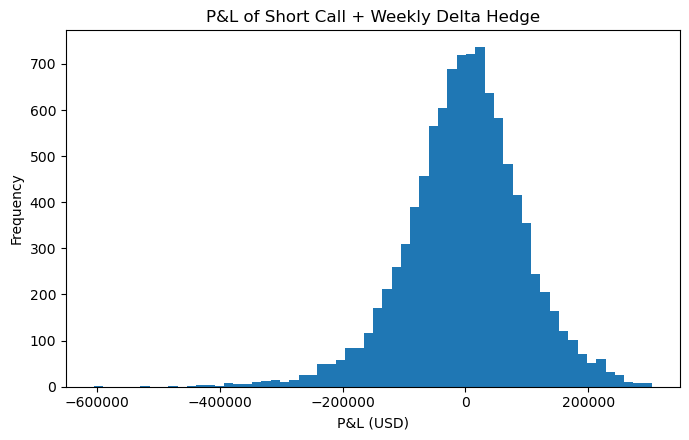

In [13]:
# Solution to (b) –––––

# Black–Scholes call price & delta
def bs_call_price_delta(S, K, r, sigma, tau):
    """Return (price, delta) of a European call (continuous r)."""
    if tau <= 0:
        price = max(S - K, 0.0)
        delta = float(S > K)
        return price, delta
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau
    price = S * stats.norm.cdf(d1) - K * np.exp(-r * tau) * stats.norm.cdf(d2)
    delta = stats.norm.cdf(d1)
    return price, delta

# Simulate GBM paths
def simulate_paths(S0, mu, sigma, T, steps, M, seed=42):
    """Simulate GBM under P, shape (M, steps+1)."""
    rng = np.random.default_rng(seed)
    dt = T / steps
    S = np.empty((M, steps + 1))
    S[:, 0] = S0
    for n in range(steps):
        Z = rng.standard_normal(M)
        S[:, n + 1] = S[:, n] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

# Perform delta-hedging simulation
def delta_hedge_sim(S_paths, K, r, sigma, taus, units):
    """Simulate delta-hedged P&L for short call."""
    M, steps_plus1 = S_paths.shape
    steps = steps_plus1 - 1
    dt = taus[0] - taus[1]  # uniform spacing
    pnl = np.zeros(M)

    for m in range(M):
        S_series = S_paths[m, :]
        C0, delta0 = bs_call_price_delta(S_series[0], K, r, sigma, taus[0])
        cash = C0 * units                     # receive option premium
        shares = delta0 * units
        cash -= shares * S_series[0]          # finance shares

        # Rehedge at each step (excluding maturity)
        for n in range(1, steps):
            cash *= math.exp(r * dt)          # accrue interest
            Cn, deltan = bs_call_price_delta(S_series[n], K, r, sigma, taus[n])
            dshares = deltan * units - shares
            cash -= dshares * S_series[n]
            shares += dshares

        # Final step: accrue, close hedge, pay payoff
        cash *= math.exp(r * dt)
        ST = S_series[-1]
        cash += shares * ST
        payoff = max(ST - K, 0.0) * units
        pnl[m] = cash - payoff

    return pnl

# Delta-hedging with parameters
def run_delta_hedge(mu=0.05, sigma_monthly=sigma_monthly, steps=13, T=0.25, M=10000):
    """Run full simulation and print results."""
    # Parameters
    S0, K = 6500.0, 6500.0
    r_nominal = 0.03
    r = np.log(1.0 + r_nominal / 4.0) / 0.25
    sigma = sigma_monthly * np.sqrt(12.0)
    contract_size, num_contracts = 100, 20
    units = contract_size * num_contracts

    # Setup
    times = np.linspace(0, T, steps + 1)
    taus = T - times

    # Simulate & hedge
    S_paths = simulate_paths(S0, mu, sigma, T, steps, M)
    pnl = delta_hedge_sim(S_paths, K, r, sigma, taus, units)

    # Summary
    stats_dict = {
        "Mean": np.mean(pnl),
        "Std": np.std(pnl, ddof=1),
        "P1": np.percentile(pnl, 1),
        "P5": np.percentile(pnl, 5),
        "Median": np.percentile(pnl, 50),
        "P95": np.percentile(pnl, 95),
        "P99": np.percentile(pnl, 99),
    }

    return pnl, stats_dict



# Run delta-hedging simulation
pnl, stats_dict = run_delta_hedge()

print(f"Delta-hedged P&L over {T*12:.0f} weeks (weekly rehedging, {M:,} paths):")
for k, v in stats_dict.items():
    print(f"{k:6}: {v:,.2f} USD")

# Plot
plt.figure(figsize=(7, 4.5))
plt.hist(pnl, bins=60)
plt.title("P&L of Short Call + Weekly Delta Hedge")
plt.xlabel("P&L (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Documentation/Figures/delta_hedge_pnl_weekly.png", dpi=300)
plt.show()

### **Question (c)**

Repeat exercise $(b)$ but now with a monthly hedging frequency.
Comment on the difference between the result of this exercise and $(b)$.

Delta-hedged P&L over 3 weeks (monthly rehedging, 10,000 paths):
Mean  : -2,694.21 USD
Std   : 190,595.65 USD
P1    : -549,533.94 USD
P5    : -336,748.33 USD
Median: 8,276.66 USD
P95   : 286,111.42 USD
P99   : 352,109.52 USD


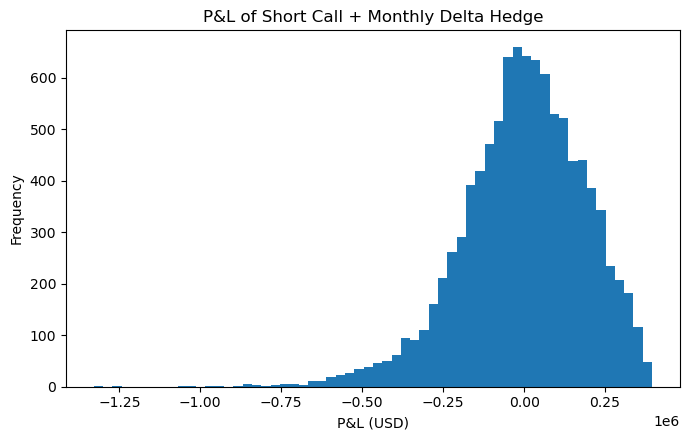

In [14]:
# Solution to (c) –––––

# Run delta-hedging simulation
# Now with monthly hedging (steps=3)
pnl, stats_dict = run_delta_hedge(steps=3)

print(f"Delta-hedged P&L over {T*12:.0f} weeks (monthly rehedging, {M:,} paths):")
for k, v in stats_dict.items():
    print(f"{k:6}: {v:,.2f} USD")

# Plot
plt.figure(figsize=(7, 4.5))
plt.hist(pnl, bins=60)
plt.title("P&L of Short Call + Monthly Delta Hedge")
plt.xlabel("P&L (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Documentation/Figures/delta_hedge_pnl_monthly.png", dpi=300)
plt.show()

### **Question (d)**

Repeat exercise $(b)$ but now with a daily hedging frequency and with a frequency of four times per day.
Comment on the difference between the results of this exercise and $(b)$ and $(c)$.

Delta-hedged P&L over 3 weeks (daily rehedging, 10,000 paths):
Mean  : -39.97 USD
Std   : 44,305.43 USD
P1    : -120,950.16 USD
P5    : -72,455.63 USD
Median: 463.46 USD
P95   : 70,539.70 USD
P99   : 114,972.76 USD


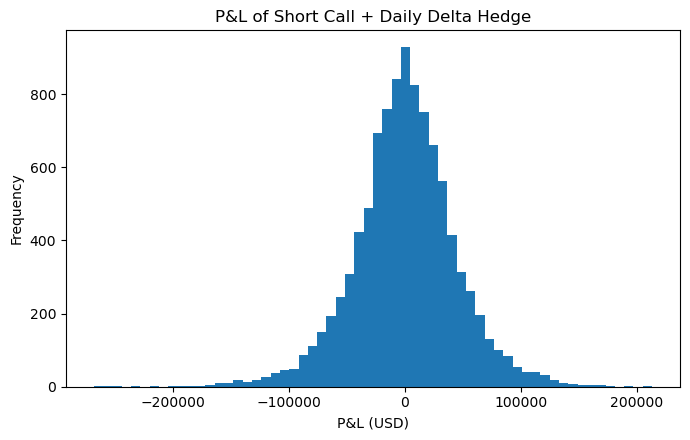

In [15]:
# Solution to (d) part 1 –––––

# Run delta-hedging simulation
# Now with daily hedging (steps=63)
pnl, stats_dict = run_delta_hedge(steps=63)

print(f"Delta-hedged P&L over {T*12:.0f} weeks (daily rehedging, {M:,} paths):")
for k, v in stats_dict.items():
    print(f"{k:6}: {v:,.2f} USD")

# Plot
plt.figure(figsize=(7, 4.5))
plt.hist(pnl, bins=60)
plt.title("P&L of Short Call + Daily Delta Hedge")
plt.xlabel("P&L (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Documentation/Figures/delta_hedge_pnl_daily.png", dpi=300)
plt.show()

Delta-hedged P&L over 3 weeks (four times daily rehedging, 10,000 paths):
Mean  : 227.21 USD
Std   : 22,773.78 USD
P1    : -61,221.84 USD
P5    : -36,667.87 USD
Median: 332.36 USD
P95   : 37,110.61 USD
P99   : 58,836.51 USD


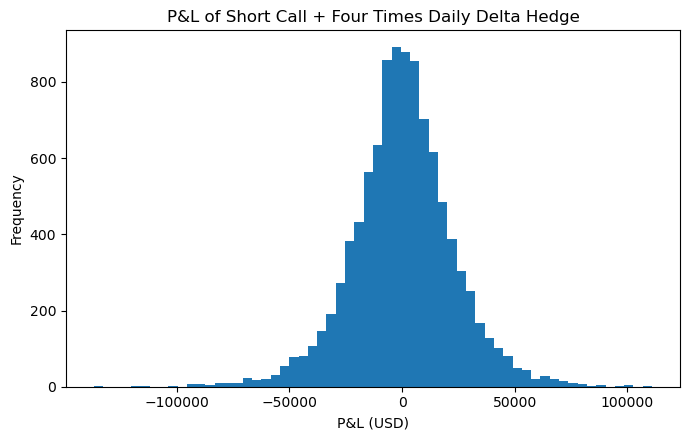

In [16]:
# Solution to (d) part 2 –––––

# Run delta-hedging simulation
# Now with four times daily hedging (steps=63*4=252)
pnl, stats_dict = run_delta_hedge(steps=63*4)

print(f"Delta-hedged P&L over {T*12:.0f} weeks (four times daily rehedging, {M:,} paths):")
for k, v in stats_dict.items():
    print(f"{k:6}: {v:,.2f} USD")

# Plot
plt.figure(figsize=(7, 4.5))
plt.hist(pnl, bins=60)
plt.title("P&L of Short Call + Four Times Daily Delta Hedge")
plt.xlabel("P&L (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Documentation/Figures/delta_hedge_pnl_four_times_daily.png", dpi=300)
plt.show()

### **Question (e)**

Repeat exercise $(d)$ but now with $\mu = 10\%$ and $\mu = 20\%$ instead of $\mu = 5\%$.
Comment on the difference between the result of this exercise and $(d)$.

Delta-hedged P&L over 3 weeks (four times daily rehedging, 10,000 paths, mu=10%):
Mean  : 262.57 USD
Std   : 22,603.49 USD
P1    : -60,989.92 USD
P5    : -36,582.10 USD
Median: 401.71 USD
P95   : 36,515.97 USD
P99   : 58,982.21 USD


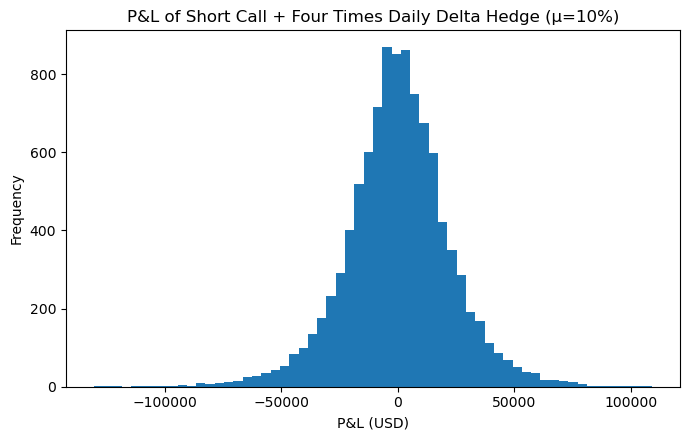

In [17]:
# Solution to (e) part 1 –––––

# Run delta-hedging simulation
# Now with four times daily hedging (steps=63*4=252) and mu=0.10
pnl, stats_dict = run_delta_hedge(steps=63*4, mu=0.10)

print(f"Delta-hedged P&L over {T*12:.0f} weeks (four times daily rehedging, {M:,} paths, mu=10%):")
for k, v in stats_dict.items():
    print(f"{k:6}: {v:,.2f} USD")

# Plot
plt.figure(figsize=(7, 4.5))
plt.hist(pnl, bins=60)
plt.title("P&L of Short Call + Four Times Daily Delta Hedge (μ=10%)")
plt.xlabel("P&L (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Documentation/Figures/delta_hedge_pnl_four_times_daily_mu_10.png", dpi=300)
plt.show()

Delta-hedged P&L over 3 weeks (four times daily rehedging, 10,000 paths, mu=20%):
Mean  : 45.44 USD
Std   : 21,792.53 USD
P1    : -59,159.29 USD
P5    : -34,730.19 USD
Median: -128.80 USD
P95   : 35,242.10 USD
P99   : 57,180.97 USD


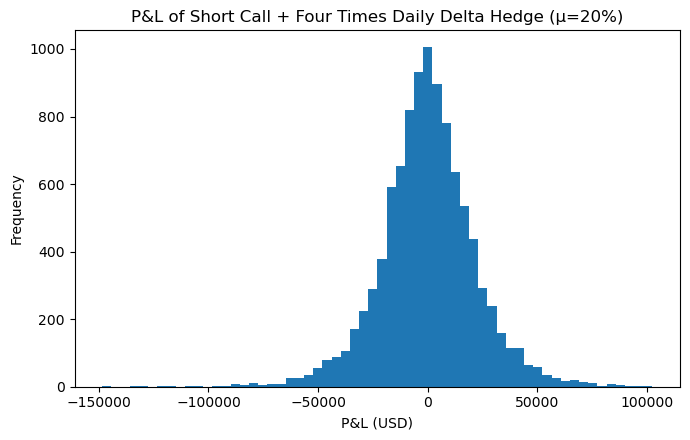

In [18]:
# Solution to (e) part 2 –––––

# Run delta-hedging simulation
# Now with four times daily hedging (steps=63*4=252) and mu=0.20
pnl, stats_dict = run_delta_hedge(steps=63*4, mu=0.20)

print(f"Delta-hedged P&L over {T*12:.0f} weeks (four times daily rehedging, {M:,} paths, mu=20%):")
for k, v in stats_dict.items():
    print(f"{k:6}: {v:,.2f} USD")

# Plot
plt.figure(figsize=(7, 4.5))
plt.hist(pnl, bins=60)
plt.title("P&L of Short Call + Four Times Daily Delta Hedge (μ=20%)")
plt.xlabel("P&L (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Documentation/Figures/delta_hedge_pnl_four_times_daily_mu_20.png", dpi=300)
plt.show()

Traders are often concerned with their gamma position and sometimes employ a delta-gamma hedging approach.

### **Question (f)**

Explain (qualitatively) why traders can be concerned about their gamma position.
Argue also under which market circumstances they are likely to be most concerned.

### **Question (g)**

Using the setting of a daily hedging frequency and 10,000 simulation paths, plot the distribution of the gamma position of the trader.
Also, investigate whether there is a relationship between the average gamma of a path and the absolute value of the trader’s P&L in a path.
Finally, explain how the risks of a gamma position can be mitigated in the context of this exercise.

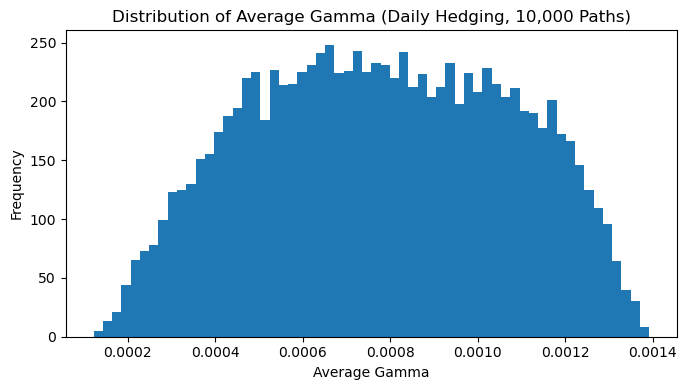

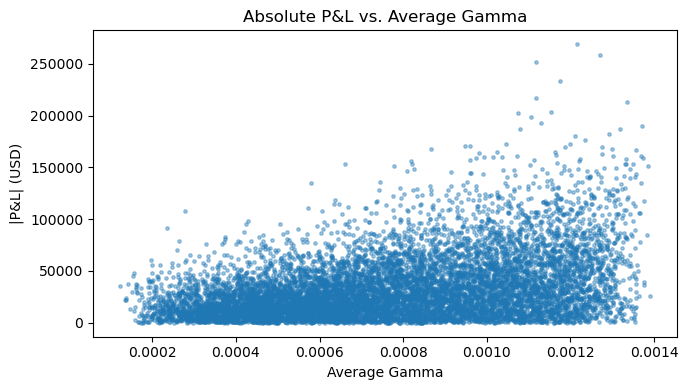

Correlation between average gamma and |PnL|: 0.375


In [20]:
# Solution to (g) –––––

# Black–Scholes gamma
def bs_call_gamma(S, K, r, sigma, tau):
    """Return the Black–Scholes gamma."""
    if tau <= 0:
        return 0.0
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt_tau)
    gamma = stats.norm.pdf(d1) / (S * sigma * sqrt_tau)
    return gamma

# Black–Scholes call price, delta, and gamma
def bs_call_price_delta_gamma(S, K, r, sigma, tau):
    """Return (price, delta, gamma) for European call."""
    if tau <= 0:
        payoff = max(S - K, 0.0)
        return payoff, float(S > K), 0.0
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau
    price = S * stats.norm.cdf(d1) - K * np.exp(-r * tau) * stats.norm.cdf(d2)
    delta = stats.norm.cdf(d1)
    gamma = stats.norm.pdf(d1) / (S * sigma * sqrt_tau)
    return price, delta, gamma

# Perform delta-hedging simulation with gamma tracking
def delta_hedge_with_gamma(S_paths, K, r, sigma, taus, units):
    M, steps_plus1 = S_paths.shape
    steps = steps_plus1 - 1
    dt = taus[0] - taus[1]
    pnl = np.zeros(M)
    avg_gamma = np.zeros(M)

    for m in range(M):
        S_series = S_paths[m, :]
        C0, delta0, gamma0 = bs_call_price_delta_gamma(S_series[0], K, r, sigma, taus[0])
        cash = C0 * units
        shares = delta0 * units
        cash -= shares * S_series[0]

        gammas = [gamma0]

        for n in range(1, steps):
            cash *= math.exp(r * dt)
            Cn, deltan, gamman = bs_call_price_delta_gamma(S_series[n], K, r, sigma, taus[n])
            dshares = deltan * units - shares
            cash -= dshares * S_series[n]
            shares += dshares
            gammas.append(gamman)

        # Final step
        cash *= math.exp(r * dt)
        ST = S_series[-1]
        cash += shares * ST
        payoff = max(ST - K, 0.0) * units
        pnl[m] = cash - payoff
        avg_gamma[m] = np.mean(gammas)

    return pnl, avg_gamma


# Run the experiment (daily hedging)
S0 = 6500.0
K = 6500.0
T = 0.25
steps = 63
M = 10000
mu = 0.05
r_nominal = 0.03
r = np.log(1 + r_nominal / 4) / 0.25
sigma = sigma_monthly * np.sqrt(12)
contract_size = 100
num_contracts = 20
units = contract_size * num_contracts

times = np.linspace(0, T, steps + 1)
taus = T - times

S_paths = simulate_paths(S0, mu, sigma, T, steps, M)
pnl, avg_gamma = delta_hedge_with_gamma(S_paths, K, r, sigma, taus, units)


# Analysis & plots
# 1. Distribution of gamma
plt.figure(figsize=(7,4))
plt.hist(avg_gamma, bins=60)
plt.title("Distribution of Average Gamma (Daily Hedging, 10,000 Paths)")
plt.xlabel("Average Gamma")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Documentation/Figures/avg_gamma_distribution.png", dpi=300)
plt.show()

# 2. Relationship between avg gamma and |PnL|
abs_pnl = np.abs(pnl)
plt.figure(figsize=(7,4))
plt.scatter(avg_gamma, abs_pnl, s=6, alpha=0.4)
plt.title("Absolute P&L vs. Average Gamma")
plt.xlabel("Average Gamma")
plt.ylabel("|P&L| (USD)")
plt.tight_layout()
plt.savefig("Documentation/Figures/abs_pnl_vs_avg_gamma.png", dpi=300)
plt.show()

# 3. Correlation
corr = np.corrcoef(avg_gamma, abs_pnl)[0, 1]
print(f"Correlation between average gamma and |PnL|: {corr:.3f}")


## **Export Python Code and Markdown Cells**

In [ ]:
# Export python code / markdown cells separately

'''
# Load notebook
nb = nbformat.read("/Users/milanpeter/Documents/University/Vrije Universiteit Amsterdam/Stochastic Processes - the Fundamentals/SPF - Computer Assignment 2/spf-assignment-2-script.ipynb", as_version=4)

# Write code cells into one python script
with open("spf-a2-script.py", "w", encoding="utf-8") as f:
    for cell in nb.cells:
        if cell.cell_type == "code":
            f.write(cell.source.replace("–", "-") + "\n\n")

# Collect markdown cells
md_cells = [cell['source'] for cell in nb.cells if cell['cell_type'] == 'markdown']

# Write them into one markdown file
with open("spf-a2-markdown.md", "w") as f:
    f.write("\n\n".join(md_cells))

# Convert markdown to LaTeX using pandoc
# run in bash
# pandoc spf-a2-markdown.md -o spf-a2-markdown.tex

'''